# Predicting Car Crash Severity in the United States
### Analysis Completed by Vaibhav Sanjay and Kashish Patel

# Part 1: Introduction

## Background
Car crashes are one of the largest causes of fatalities in the United States. Analysis of car accidents is useful for locating accident-prone regions, analyzing effects of weather, and predicting accidents. We analyze a countrywide dataset of car accidents to understand patterns in car crashes and predict the severity of them based on various parameters such as location, precipitation, time, and various other factors.

We used the [US Accidents (2016-2021)](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents) dataset on Kaggle for our analysis [[1]](#1). The dataset includes 2.8 million points of accident data from February 2016 to December 2021 and covers 49 states.

## Motivation
This is a tutorial on how to use data science strategies and libraries to analyze large data sets with Python. Some of the topics we will be discussing are
- Cleaning and organizing data with Pandas
- Creating heatmap visualizations
- Plotting variables in bar charts, violin plots, and other graphical visualizations
- Normalizing and encoding data for machine learning
- Training and scoring machine learning models

By the end of this tutorial you should be able to apply these techniques to your own datasets.

# Part 2: Data Wrangling
Our first task will be to unpack the accidents dataset and see what we are working with.

## Imports
This notebook depends on [pandas](https://pandas.pydata.org/docs/), [matplotlib](https://matplotlib.org/stable/index.html), [plotly](https://plotly.com/python/), [colour](https://pypi.org/project/colour/), [statistics](https://docs.python.org/3/library/statistics.html), and [sklearn](https://scikit-learn.org/stable/)

Throughout this notebook, we will provide specific documentation links for more unique uses of the above libraries. For other cases, please refer to the library documentation links above.

In [1]:
# Run this if plotly or colour aren't installed
%pip install plotly
%pip install colour

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams as plt_params
from matplotlib.pyplot import figure
import plotly.express as px
from statistics import mode
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import cross_val_score
import plotly.io as pio
from colour import Color
pio.renderers.default = 'iframe'

## Reading in the Data & Initial Steps
We start by reading in the data from our downloaded CSV file into a [Pandas Dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). Note that there is _a lot_ of data, so running this cell and most others make take a few seconds to complete.

In [40]:
data = pd.read_csv('./US_Accidents_Dec21_updated.csv', nrows=5000)
# data = pd.read_csv('./US_Accidents_Dec21_updated.csv')

Let's take a look at the columns we have to get familiar with how our data is structured.

In [5]:
data.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

So each accident has its own ID as well as some important contextual information such as a start time, end time, location, and weather information. Let's take a look at our raw data as a dataframe.

In [6]:
data.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


## Initial Filtering

We can see that some of these columns are not important/relevant to our analysis. Here is a list of these columns and explanations of why we don't need them:

- "Description" - too messy and does not provide much useful information.
- "Number", "Street", "Side", "City", "County", "Zipcode", "Timezone", and "Airport_Code" - all provide location information that is not as specific as latitude, longitude and city.
- "Country" - not useful as this dataset only looks at the US
- "End_Lat" and "End_Lng" - since we already have the start latitude and longitudes as well as the distance, these features are not very important
- "Weather timestamp" - shows the timestamp that weather data is collected. This is not very significant.
- "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight" and "Astronomical_Twilight" - different measure for when sunset occurs. This does not seem very important, and we will use the time in favor of this.
- "ID" - We don't need individual identification of accidents

In [41]:
# list of all features we are removing right now
to_remove = ["Description", "Number", "Street", "Side", "City", "County","Country", "Zipcode", 
    "Timezone", "End_Lat", "End_Lng", "Airport_Code", "Weather_Timestamp", "Sunrise_Sunset", 
    "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight", "ID"]

# remove the necessary columns
data = data.drop(to_remove, axis=1, errors='ignore')

# Part 3: Data Exploration
Now we are ready to analyze our data. We have several methods for analyzing this data set, most of which analyze the relationship between the severity of accidents and the other variables (columns).

## Styling Plots
This function uses [colour](https://pypi.org/project/colour/) to style the colors of our plots with a gradient later on. This makes our plots look a little nicer.

In [4]:
# this function takes a list, and option "low" color, "high" color, and "middle" color
# and generates a list of colors ranging from low->middle->high, with higher values in the input
# list corresponding to colors closer to "high", and lower values corresponding to "low"
def gen_colors(lst, low="yellow", high="darkorange", middle=None):
    # create the gradient of colors
    gradient = list(Color(low).range_to(high, len(lst)))

    # reorganize the gradient list to match elements in the input list
    srted = sorted(lst)
    colors = []
    for item in lst:
        colors.append(gradient[srted.index(item)])
    return [color.hex for color in colors]

plt_params['figure.dpi'] = 75
plt_params['figure.figsize'] = (15, 6)

## Graphing Accident Locations
We are given the state acronyms for every accident with the "State" column. Using this data, we create a [chloropleth](https://plotly.github.io/plotly.py-docs/generated/plotly.express.choropleth.html) plot with plotly for the frequency of car accidents across the United States, grouped by state.

In [8]:
# Plotly wants a dataframe but the value_counts method gives a series
# Gather the frequencies of car accidents for each state into a DataFrame",
freqs = data['State'].value_counts().rename_axis('State').reset_index(name='Accidents')

# create the map
fig = px.choropleth(
    freqs,
    locations='State',
    color='Accidents',
    locationmode='USA-states',
    color_continuous_scale='blues',
    title='Frequency of Car Accidents in the US (2016-2021)',
    scope='usa'
)

fig.show()

The above map shows which states have the highest frequencies of car accidents, with darker shades of blue indicating higher frequencies and lighter shades indicating a lower frequency.

We can see that states like California and Florida have the highest frequency of car accidents, according to our dataset. But, we have to consider different factors that may cause this. First and foremost, these states have high population relative to the other states, so that may play a large role in their high frequencies of car accidents. Second, these states may just be better at reporting accidents than other states, so even if other states had much more accidents, they may just go unreported.

As a result of this, we will now look at the average severity of car accidents in each state. This will tell us which states have, on average, the most severe car accidents and will minimize any bias towards certain states that comes from doing a simple frequency map.

To take the average of each individual state, we can take advantage of [Pandas groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html).

In [9]:
# Average the severity of the accidents of car accidents for each state
severity = pd.DataFrame(data.groupby(by='State').apply(lambda x: x['Severity'].mean())).reset_index()
severity.columns = ['State', 'Severity']

# Create the figure
fig = px.choropleth(
        severity,
        locations='State',
        color='Severity',
        locationmode='USA-states',
        color_continuous_scale='reds',
        title='Severity of Car Accidents in the US by State (2016-2021)',
        scope='usa'
)

fig.show()

This is notably different from the previous map. We can see that while Wisconsin may have notably few accidents they typically have more severe accidents as compared to other states. Furthermore, midwestern states such as Wyoming and Colorado also have high severity accidents, while states near the borders seems to have less severe accidents.

## Graphing Accident Times
Next, we will use the time-related data to explore when most accidents happen.

### Accidents on Days of the Week
The matplotlib library is useful for making several kinds of plots. We will make a [violin plot](https://matplotlib.org/stable/gallery/statistics/violinplot.html) using matplotlib that displays each day of the week as a separate violin, each as a mini-time series showing when accidents occur most frequently. To do this, we will need to group the data by the day of week first, then collect the hours of each observation for each of these groups.

In [42]:
# turn the start times into actual datetimes
data['Start_Time'] = pd.to_datetime(data['Start_Time'], infer_datetime_format=True)

# add two new series to our DataFrame that represent the day of week and hour of the car accidents
data['Day'] = data['Start_Time'].apply(lambda x: x.dayofweek)
data['Hour'] = data['Start_Time'].apply(lambda x: x.hour)

# create a list of lists with each inner list representing a different day of the week that contains the hours that an accident occurs
grouped_by_day = data.groupby(by='Day')
hour_foreach_day = grouped_by_day.apply(lambda x: x['Hour'].tolist()).tolist()

Now that we have grouped our data, we will create the violin plots for each day of the week. We also want to show when the "mode" occurs for each day of the week. This is the time when the most accidents happen. We add a small line for each mode by [customizing the violin plot](https://matplotlib.org/stable/gallery/statistics/customized_violin.html).

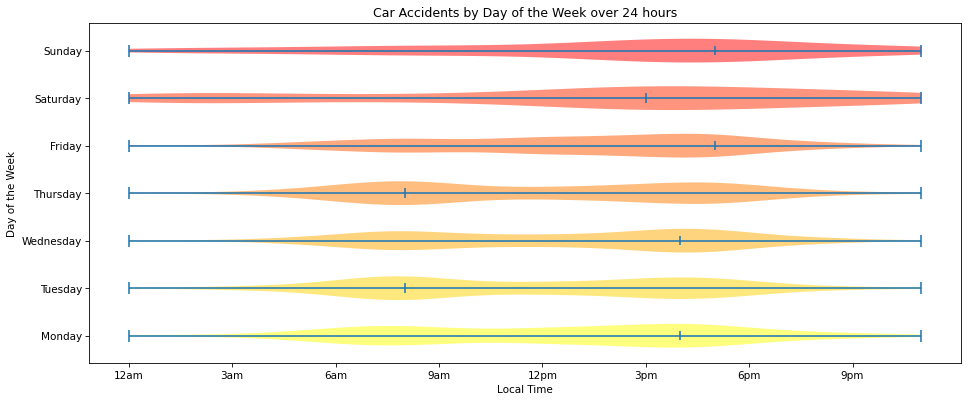

In [43]:
# create the violin plot
fig, ax = plt.subplots()
violins = ax.violinplot(dataset=hour_foreach_day, positions=range(len(hour_foreach_day)), vert=False)

# add lines marking the mode for each day, representing the time where most accidents happen
bodies = violins['bodies']
modes = [mode(x) for x in hour_foreach_day]
ax.vlines(modes, list(map(lambda x: x-0.1, range(len(bodies)))), list(map(lambda x: x+0.1, range(len(bodies)))))

# add colors to help differentiate each violin
colors = gen_colors(range(len(bodies)), "yellow", "red", "orange")
for i in range(len(bodies)):
    bodies[i].set_facecolor(colors[i])
    bodies[i].set_alpha(0.5)

# add labels to plot
plt.yticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Car Accidents by Day of the Week over 24 hours")
plt.xlabel("Local Time")
plt.ylabel("Day of the Week")
plt.xticks(ticks=[0, 3, 6, 9, 12, 15, 18, 21], labels=["12am", "3am", "6am", "9am", "12pm", "3pm", "6pm", "9pm"])
plt.show()

This graph makes sense if we take some prior assumptions into account. On the weekdays we can see humps at around 7-8am and again around 4pm. On the weekends we see more humps at midday and in the afternoon. This coincides with times when people usually go to work, leave work, and go out on weekends. During these times there are likely to be more cars on the road, leading to more accidents.

### Accidents Over the Past Few Years
We can look at the times that accidents happen more generally. Let's consider the average severity of accidents over the entire timespan. We take the average accident severity for each year of collected data from 2016-2021. Again, we can take advantage of groupbys to group the accidents by year, and then find the average severity.

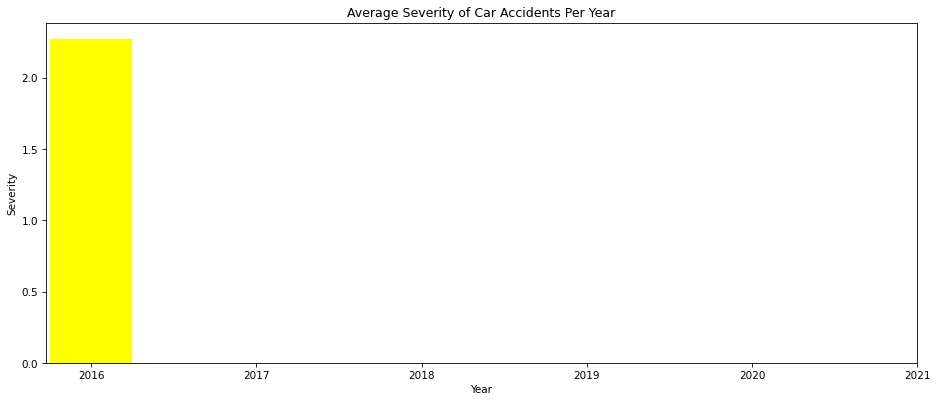

In [44]:
data['Year'] = data['Start_Time'].apply(lambda x: x.year) # A new column with the year of the accident

# Group by the year and find the mean of Severity
grouped_by_year = data.groupby(by='Year')
severities = grouped_by_year.apply(lambda x: x['Severity'].mean())

# Plot the bar chart
plt.bar(height=severities, x=severities.index, width=0.5, color=gen_colors(severities, "yellow", "orange"))
plt.xticks(range(2016, 2022))
plt.title('Average Severity of Car Accidents Per Year')
plt.xlabel('Year')
plt.ylabel('Severity')
plt.show()

It seems like accident severity has been tending down over the last four years. There may be no significant reason for this, but one possibility is that there were less cars on the road over the COVID-19 time period.

## Graphing Accident Weather
We have a lot of columns related to weather. We proceed by making some graphs based on the weather conditions during accidents.

### Most Common Weather Conditions
First we consider the `Weather_Condition` column. We can take a look at the different values in this column.

In [13]:
data['Weather_Condition'].value_counts().to_csv('weather_conditions.csv') # Open weather_conditions.csv to look for yourself
print(f"There are {len(data['Weather_Condition'].unique())} different weather condition descriptions!")

There are 20 different weather condition descriptions!


There are quite a lot of different values to analyze. Let's take a look at the top 6 most common conditions and compare the number of accidents for each of them using a [stacked bar chart](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html).

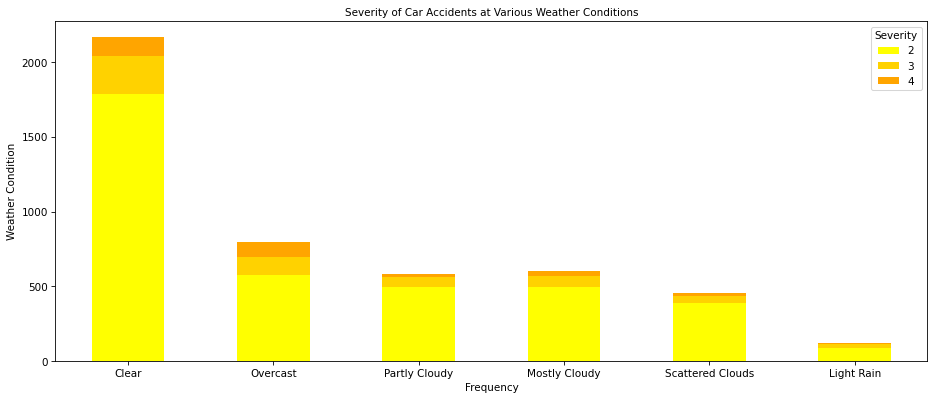

In [14]:
data.groupby(['Weather_Condition', 'Severity']).size().unstack().sort_values(
    by=2, ascending=False)[:6].plot(kind='bar', stacked=True, xlabel='Frequency', ylabel='Weather Condition', color=gen_colors(range(3), "yellow", "orange"))
plt.xticks(rotation = 0)
plt.title('Severity of Car Accidents at Various Weather Conditions', fontsize=10)
plt.show()

Now we can try to analyze the data over all the weather conditions.

### Generalizing Weather Conditions
If we take a closer look at the weather conditions, some of them are very similar to each other (for example "Thunder" and "T-Storm"). In order to generalize all of these weather conditions, we make broader categories for some of these weather conditions. An alternative could have been to just use the top 6 weather conditions and drop any rows with any other wording, however we would lose a nontrivial amount of data that we can easily classify into a few categories. The categories we chose are
- Snow (Anything related to snow, winter, freezing, hail, or ice)
- Rain (Anything related to rain, drizzle, thunder, storm, or precipitation)
- Cloudy (Anything related to cloud or overcast)
- Clear (Anything related to clear or fair)

Note that this does not cover the weather conditions that have something to do with visibility (for example "Haze", "Fog", "Smoke"). This is because adding the extra column may add some unwanted colinearity between this column and some others. More specifically, a "0" entry in the four other entries already implies the weather was "Haze," "Fog," or something similar, so it would be unnecessary to add this extra column. Also, there is already a column for visibility in our data, so adding this column wouldn't really give us any better information than the visibility column would.

In [45]:
# this function will take an entry from the "Weather_Condition" column and keywords for one of the four weathers
# we chose to classify it by returning 1 if it should be considered as that type of weather and 0 if not
def classify_weather(weather, keywords):
    # check if the data is missing (nan)
    if type(weather) != str:
        return 0
    # check if any of the keywords are in the weather
    return int(any(x in weather for x in keywords))

# The list of weather options
# Feel free to edit this dict to add more options!
weathers =  {
            'Snow': ['Snow', 'Freez', 'Hail', 'Ice', 'Wint'],
            'Rain': ['Rain', 'Drizzle', 'Thunder', 'Storm', 'Precipitation'],
            'Cloudy': ['Cloud', 'Overcast'],
            'Clear': ['Clear', 'Fair']
            }

# Make a new column for each weather option by calling our classify_weather function and weathers dict
for key, value in weathers.items():
    data[key] = data['Weather_Condition'].apply(lambda x: classify_weather(x, value))

Now we compare the severity of accidents based on the selected weather conditions.

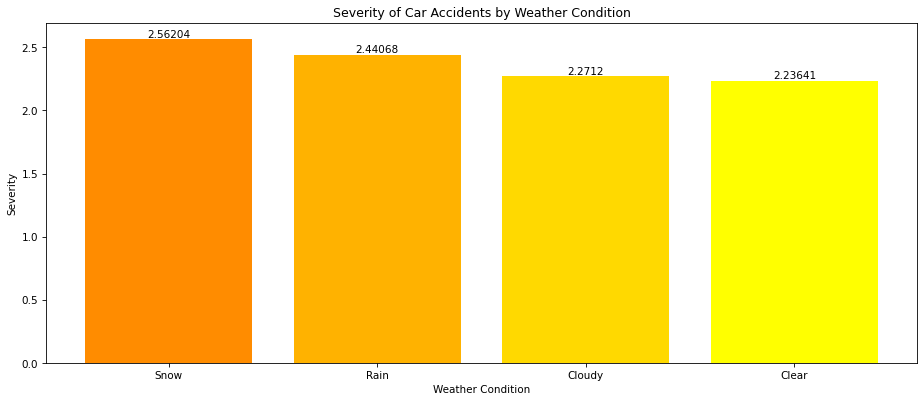

In [46]:
# Take the mean for each weather option
weather_severity = pd.Series([data[data[x] == 1]['Severity'].mean() for x in weathers.keys()])

# Plot the graph
fix, ax = plt.subplots()
bars = ax.bar(weathers.keys(), weather_severity, color=gen_colors(weather_severity, "yellow", "darkorange"))
ax.bar_label(bars)
plt.title("Severity of Car Accidents by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Severity")
plt.show()

From this bar chart it is not very clear what the difference in weathers really is in terms of accident severity. We can tell that snowy accidents are probably more severe than clear ones, but it's not clear if this is statistically significant. However, since we are dealing with over a million data points, the small differences might add up. We can do do [normalization with z-scores](https://developers.google.com/machine-learning/data-prep/transform/normalization#z-score) to make these differences clearer.

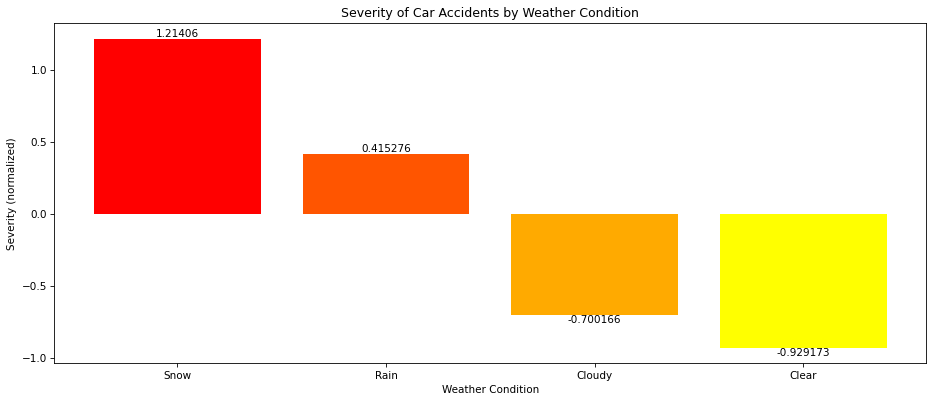

In [47]:
fix, ax = plt.subplots()

# Normalize our data
# Calculate z-score for every point
normalized_severities = (weather_severity - weather_severity.mean())/weather_severity.std()

# Plot the normalized graph
bars = ax.bar(weathers.keys(), normalized_severities, color=gen_colors(normalized_severities, "yellow", "red"))
ax.bar_label(bars)
plt.title("Severity of Car Accidents by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Severity (normalized)")
plt.show()

Now we can see a clear difference in the severity. When the weather is clear, accidents are on average less severe than on days with rain or snow.

# Part 4: Building a Machine Learning Model
Our goal in this section is to train a model that predicts the severity of an accident. From the previous sections, we can see that weather, time, and location may affect the severity of accidents. Our model should use elements such as weather, temperature, location and time to make predictions on the accident severity.

## Setting up Data for Machine Learning
Let's take a look at the current state of our data.

In [48]:
data.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),State,Temperature(F),Wind_Chill(F),Humidity(%),...,Traffic_Calming,Traffic_Signal,Turning_Loop,Day,Hour,Year,Snow,Rain,Cloudy,Clear
0,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,3.230,OH,42.1,36.1,58.0,...,False,False,False,0,0,2016,0,1,0,0
1,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,0.747,OH,36.9,NaN,91.0,...,False,False,False,0,5,2016,0,1,0,0
2,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,0.055,OH,36.0,NaN,97.0,...,False,False,False,0,6,2016,0,0,1,0
3,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,0.123,OH,39.0,NaN,55.0,...,False,False,False,0,6,2016,0,0,1,0
4,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,0.500,OH,37.0,29.8,93.0,...,False,False,False,0,7,2016,0,1,0,0


There are two main issues with using this dataframe for machine learning.
- Unusuable data types such as datetimes, strings, and booleans
- Not a Number (NaN) values

We attempt to deal with these issues individually.

### One Hot Encoding
By default, machine learning models like to operate on numbers. So state abbreviations like "OH" and datetimes for the start of an accident will cause issues when attempting to train a model. To resolve this, we apply a technique called [One Hot Encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). This turns our categorical data into a numerical form by creating a column for each category. Pandas supplies us with another handy function called [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) that does this process for us.

While one hot encoding is very useful, it has some drawbacks. If we have a large amount of different categories (for example like we saw for `Weather_Condition`) we generate a similarly large amount of new columns. A large amount of columns is not useful for the machine learning training. To mitigate this, we simply remove the `Start_Time`, `End_Time` and `Weather_Condition` Columns (We captured the weather condition with the 4 weather categories defined in the previous section, and using the date of an accident in the past is not very useful for predicting the severity of accidents on future dates).

In [52]:
# Do one hot encoding
data = pd.get_dummies(data.drop(["Start_Time", "End_Time", "Weather_Condition"], axis=1, errors='ignore'))
data.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Wind_Direction_SE,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,3,40.108910,-83.092860,3.230,42.1,36.1,58.0,29.76,10.0,10.4,...,0,0,0,1,0,0,0,0,0,0
1,2,39.865420,-84.062800,0.747,36.9,NaN,91.0,29.68,10.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2,39.102660,-84.524680,0.055,36.0,NaN,97.0,29.70,10.0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2,41.062130,-81.537840,0.123,39.0,NaN,55.0,29.65,10.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,3,39.172393,-84.492792,0.500,37.0,29.8,93.0,29.69,10.0,10.4,...,0,0,0,0,0,0,0,0,1,0


### Dealing with NaNs
Let's see which columns have NaN values and how many they have.

In [53]:
data.isna().sum()

Severity                      0
Start_Lat                     0
Start_Lng                     0
Distance(mi)                  0
Temperature(F)               30
Wind_Chill(F)              4412
Humidity(%)                  34
Pressure(in)                 19
Visibility(mi)               56
Wind_Speed(mph)             605
Precipitation(in)          4633
Amenity                       0
Bump                          0
Crossing                      0
Give_Way                      0
Junction                      0
No_Exit                       0
Railway                       0
Roundabout                    0
Station                       0
Stop                          0
Traffic_Calming               0
Traffic_Signal                0
Turning_Loop                  0
Day                           0
Hour                          0
Year                          0
Snow                          0
Rain                          0
Cloudy                        0
Clear                         0
State_CA

There are [several ways](https://medium.com/@andykashyap/5-simple-ways-to-deal-with-nan-in-your-data-c064289b6112) to deal with NaN values. The method chosen varies between data sets and the desired end goal. Let's see the best option in our case for each of the columns with NaN values.
- Precipitation(in): If there is an NaN in this series, we replace the value with 0. If there was no value reported then there was no rain.
- Wind_Chill(F): This column contains many NaN values, but there isn't a "default" value like with precipitation. So we chose to drop this column since the data inside cannot be very useful
- All other columns: Since all other columns only have a relatively small fraction of their data as NaN, we choose to set the NaN values to the average of the other values. It turns out this strategy is pretty effective if we only affect a small portion of the data.

In [55]:
data = data.drop('Wind_Chill(F)') # Remove this column
data['Precipitation(in)'] = data['Precipitation(in)'].fillna(0) # Fill NaN values with 0
data = data.fillna(data.mean()) # Fill NaN columns with the mean
data.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Wind_Direction_SE,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,3,40.108910,-83.092860,3.230,42.1,36.100000,58.0,29.76,10.0,10.40000,...,0,0,0,1,0,0,0,0,0,0
1,2,39.865420,-84.062800,0.747,36.9,23.330272,91.0,29.68,10.0,10.31479,...,0,0,0,0,0,0,0,0,0,0
2,2,39.102660,-84.524680,0.055,36.0,23.330272,97.0,29.70,10.0,10.31479,...,0,0,0,0,0,0,0,0,0,0
3,2,41.062130,-81.537840,0.123,39.0,23.330272,55.0,29.65,10.0,10.31479,...,0,0,0,0,0,0,0,0,0,0
4,3,39.172393,-84.492792,0.500,37.0,29.800000,93.0,29.69,10.0,10.40000,...,0,0,0,0,0,0,0,0,1,0


Now our data is ready for machine learning.

## Training and Testing a Machine Learning Model
Our first step will be to choose the type of model we want to train.

### Choosing a Machine Learning Model
There are many types of machine learning models, each excelling at their own tasks. Our task is classification: Given some data about an accident we want to classify the severity of the accident as 1, 2, 3, or 4. We chose the [Decision Tree](https://scikit-learn.org/stable/modules/tree.html) model for this task, since they are good for classification problems and allow us to see which variables affect the output.

### Training the Model
The training and evaluation of our model is done using sklearn. Sklearn supports numerous different machine learning models, including the decision tree classifier. The Decision Tree link above goes into detail about the functionality.

In [56]:
X = data.drop(['Severity'], axis=1) # The data to train on, we ask the model to classify a car accident given this information
y = data['Severity'] # The "answer" to the classification

# Create and train the decision tree
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=7).fit(X, y)

A decision tree can also be [displayed](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) with sklearn. Let's see which decisions are the most important by displaying the top few layers.

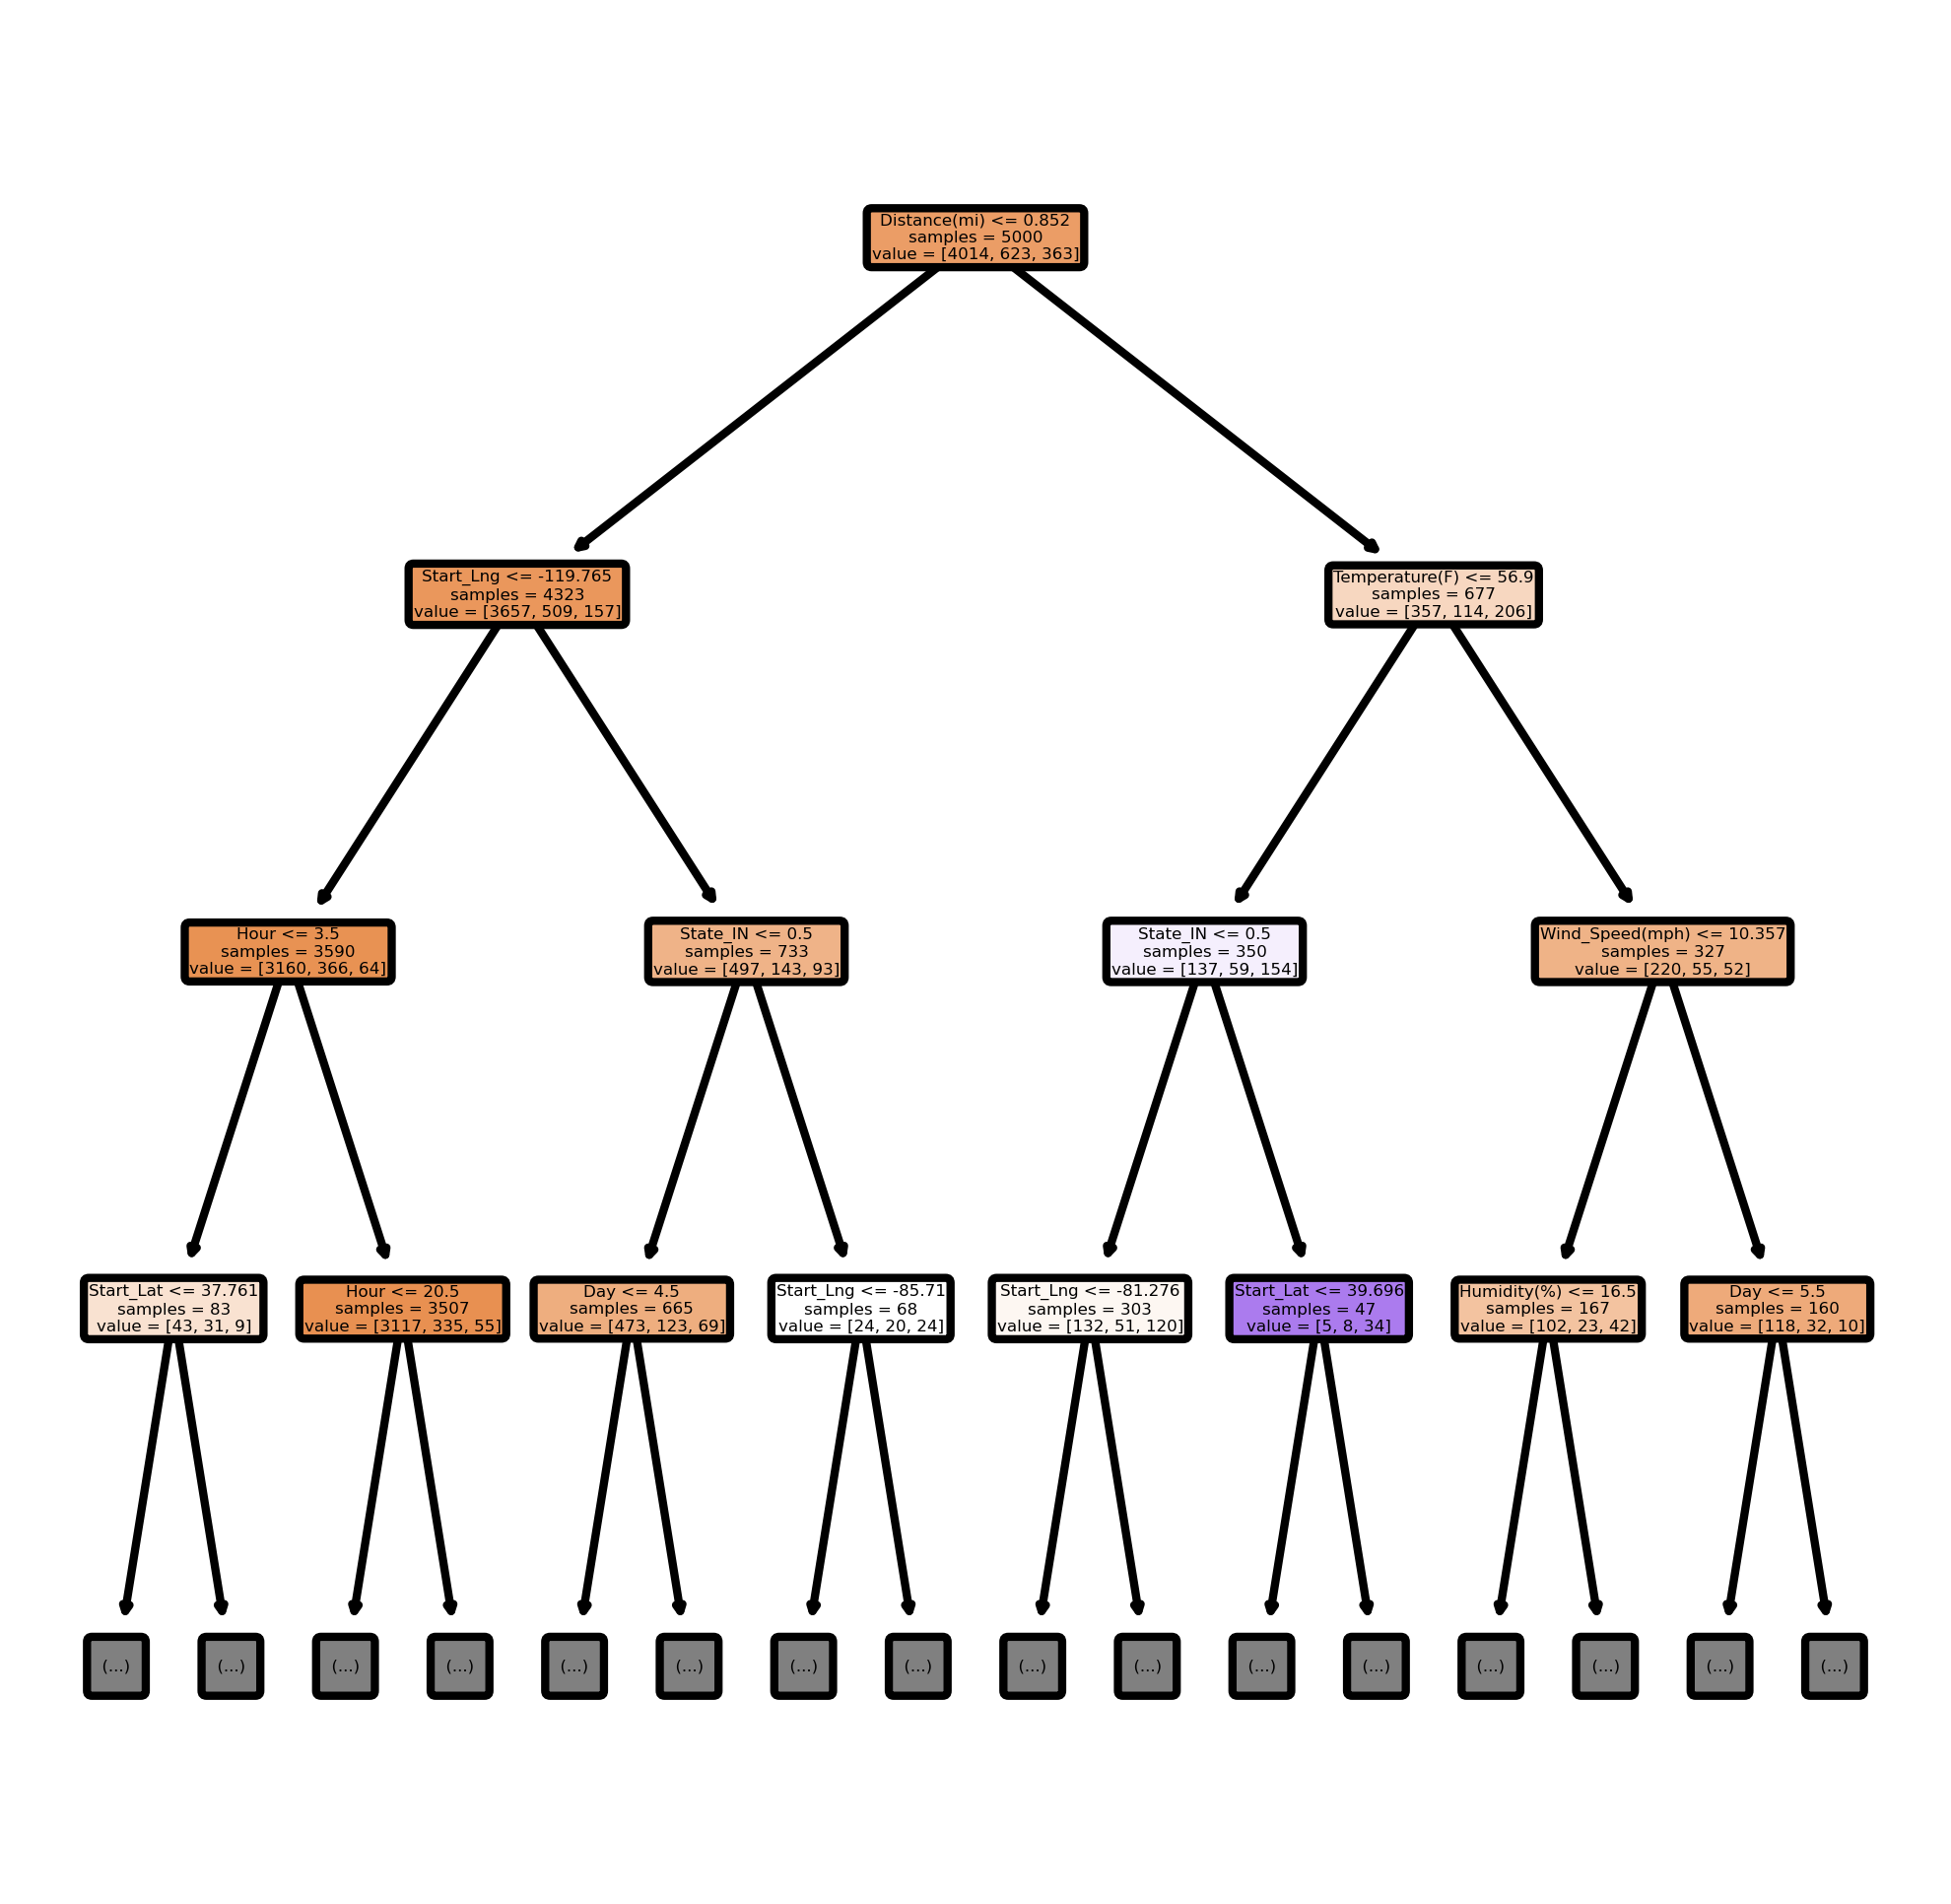

In [57]:
# Display the decision tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600)
tree.plot_tree(decision_tree,
           feature_names = list(X.columns),
           filled = True,
           max_depth=3,
           fontsize=2,
           rounded=True,
           impurity=False);

**ADD DISCUSSION OF TREE HERE**

### Cross Validation

In [58]:
cross_val_score(decision_tree, X, y, cv=10)

array([0.244, 0.608, 0.81 , 0.782, 0.816, 0.788, 0.8  , 0.768, 0.79 ,
       0.798])

# Citations
- <a id="1">[1]</a> 
Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.
- <a id="2">[2]</a> 
Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.